# Comparison between full song synthesis and on partial synthesis

The goal of this notebook is to see if a whole song synthesis can be approximated by partial syntheses. If a segment of a full song is equivalent to a synthesis of the synthesis of the segment, then we can speed up the algorithm by generating only the interesting parts when training gestures.

This analysis shows that even if a segment of the whole song synthesis is really similar with the synthesis of a segment, it is not strictly equivalent and can have big impact in the measurements. The impacted measurements seem to be the one that are phase dependant, or the already most noisy features: fm and goodness.

We still use only partial optimisation in the real algorithm because even if it's not strictly equivalent, it speeds up the model execution significantly.

In [17]:
%pylab --n
%matplotlib inline
import seaborn as sns
import birdsonganalysis as bsa
from scipy.io import wavfile
from IPython.display import Audio, display

sns.set_palette('colorblind')

import sys

sys.path.append('../model/')
from song_model import SongModel
from gesture_fitter import fit_gesture_padded, fit_gesture_whole
from measures import bsa_measure
from synth import synthesize

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [39]:
sr, ts = wavfile.read('../data/ba_example.wav')
sm = SongModel(song=ts, priors=[
  0, 0, 3.141592653589793, 15,
  0, 0, 0.39269908169872414, 45,
  0, 0, 0, 5000,
  0,
  0, 0, 0, 0, 0.15
  ])

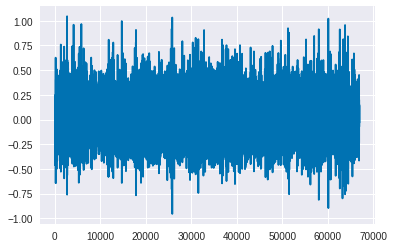

In [40]:
plt.plot(sm.gen_sound(fixed_normalize=False))

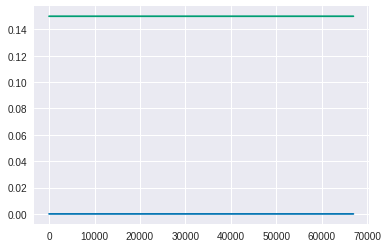

In [41]:
plt.plot(sm.gen_alphabeta())

In [21]:
ab = np.loadtxt('../data/ba_example_ab.dat')

In [22]:
synth_whole = synthesize(ab, fixed_normalize=True)

In [23]:
beg = 1454
end = beg + 10781

In [24]:
synth_part = synthesize(ab[beg:end+2], fixed_normalize=True)

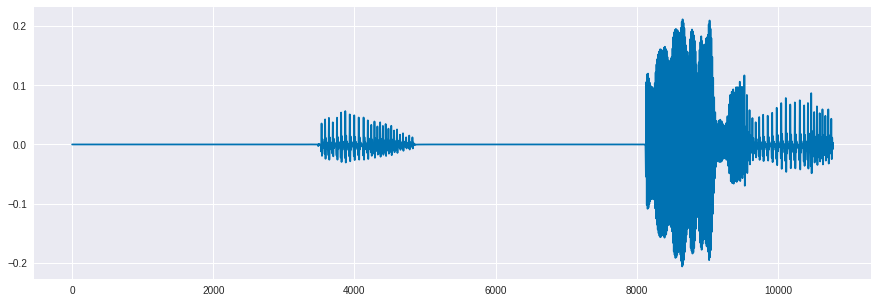

In [25]:
plt.figure(figsize=(15, 5))
plt.plot(synth_whole[beg:end])

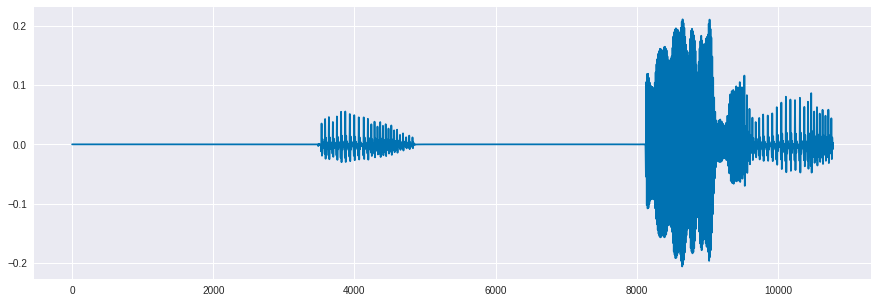

In [26]:
plt.figure(figsize=(15, 5))
plt.plot(synth_part)

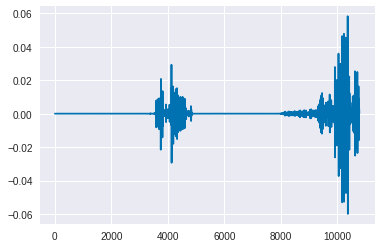

In [27]:
plt.plot(synth_whole[beg:end] - synth_part)

In [28]:
Audio(data=synth_part, rate=44100)

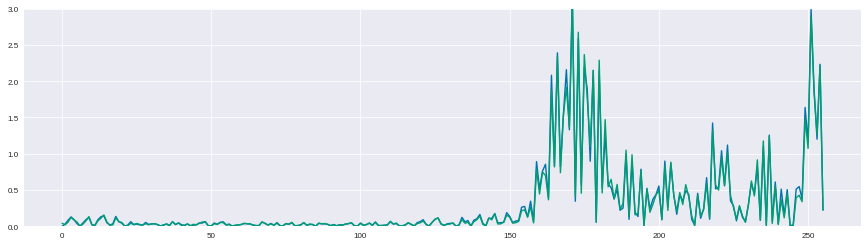

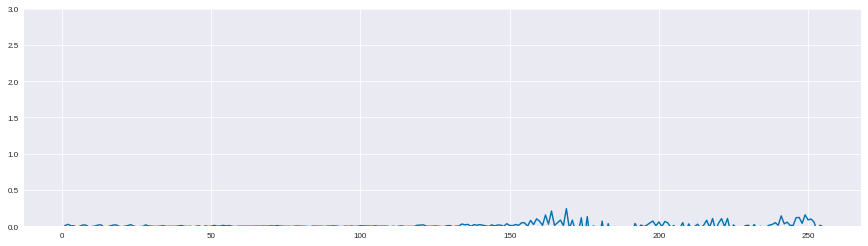

In [29]:
f = np.fft.fft(synth_part) 
f = (f * f.conj()).real
f2 = np.fft.fft(synth_whole[beg:end]) 
f2 = (f2 * f2.conj()).real
with sns.plotting_context('paper'):
    plt.figure(figsize=(15, 4))
    plt.plot(f[:256])
    plt.plot(f2[:256])
    plt.ylim((0, 3))
    plt.show()
    plt.figure(figsize=(15, 4))
    plt.plot((f - f2)[:256])
    plt.ylim((0, 3))
    plt.show()

In [30]:
Audio(data=synth_whole[beg:end], rate=44100)

In [31]:
part_feat = bsa.all_song_features(synth_part, 44100, freq_range=256, fft_step=40, fft_size=1024)
whole_feat = bsa.all_song_features(synth_whole, 44100, freq_range=256, fft_step=40, fft_size=1024)

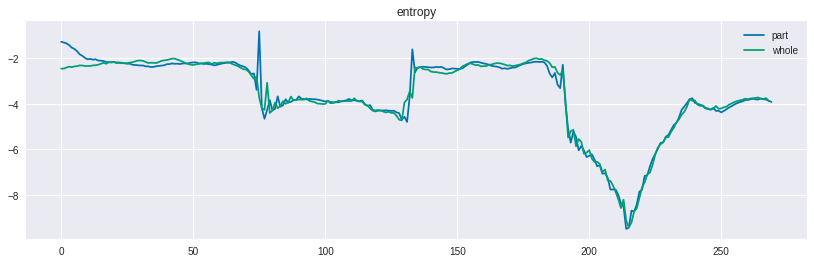

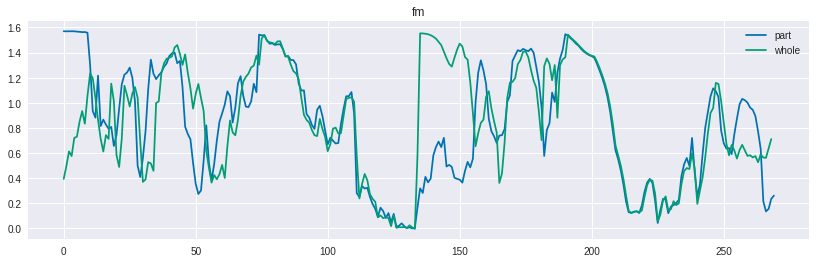

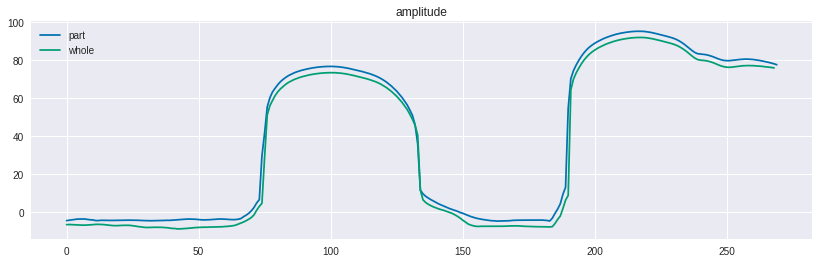

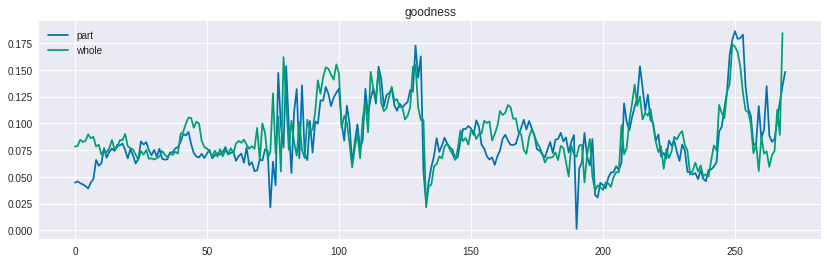

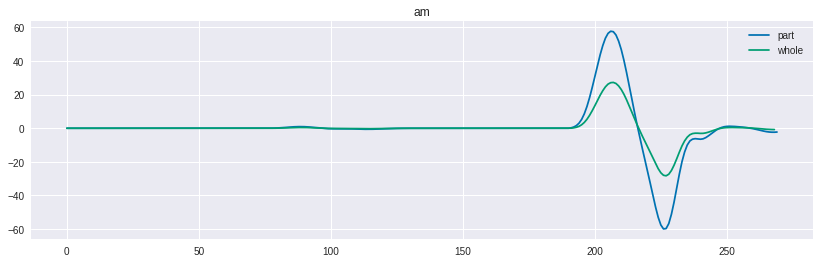

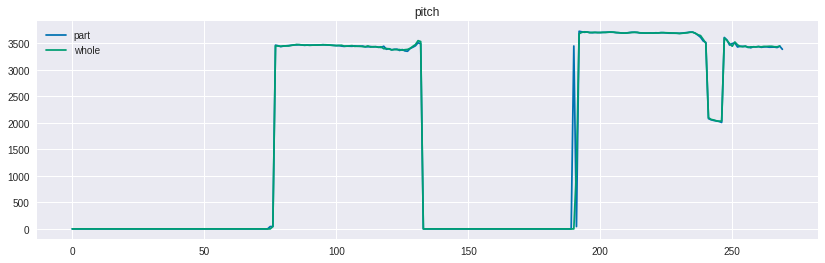

In [32]:
for nfeat in part_feat:
    plt.figure(figsize=(14, 4))
    plt.plot(part_feat[nfeat], label="part")
    plt.plot(whole_feat[nfeat][beg//40:end//40], label="whole")
    plt.legend()
    plt.title(nfeat)
    plt.show()

In [33]:
whole_feat

defaultdict(<function birdsonganalysis.songfeatures.all_song_features.<locals>.<lambda>>,
            {'am': array([  1.75222258e-07,   1.78360427e-07,   1.74180946e-07, ...,
                     -1.73797589e-07,  -1.80480354e-07,  -1.79765899e-07]),
             'amplitude': array([-9.7395751 , -9.50272567, -9.28253129, ..., -7.93843786,
                    -8.26237769, -8.56394565]),
             'entropy': array([-1.59240717, -1.56864443, -1.60280529, ..., -1.73599301,
                    -1.67263867, -1.64345414]),
             'fm': array([ 1.57021394,  1.56943157,  1.56890431, ...,  1.54259615,
                     1.54480487,  1.54730512]),
             'goodness': array([ 0.05204851,  0.05313075,  0.05640074, ...,  0.04672779,
                     0.04858231,  0.04988447]),
             'pitch': array([ 0.,  0.,  0., ...,  0.,  0.,  0.])})

In [34]:
out = []
for i in range(100):
    out.append(np.linalg.norm(synth_whole[(beg+100+i):(end-100+i)] - synth_part[100:-100]))

In [35]:
np.argmin(out)

0

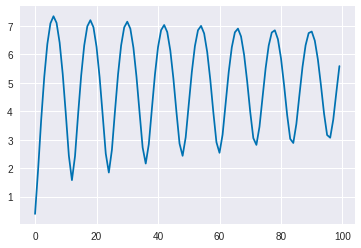

In [36]:
plt.plot(out)

In [37]:
from measures import bsa_measure

conf = {'measure_obj': lambda x: bsa_measure(x, 44100),
        'comp_obj': lambda x, y: np.linalg.norm(x - y), 'iter_per_train': 50,
        "mins": [
    -50, 0, -3.141592653589793, 0,
    -50, 0, -3.141592653589793, 0,
    -50, 0, -3.141592653589793, 0,
    -5,
    -50, 0, -3.141592653589793, 0, -3
  ],
  "maxs": [
    50, 4, 3.141592653589793, 40000,
    50, 4, 3.141592653589793, 40000,
    50, 5, 3.141592653589793, 40000,
    10,
    50, 3, 3.141592653589793, 1000, 2
  ],
         "dev": [
    0.2,   0.2,   0.05,  10,
    0.1,  0.1,  0.1,  10,
    0.001, 0.001, 0.005, 100,
    0.5,
    0.2, 0.2, 0.05, 10, 0.05
  ],
    "coefs": {"am": 0, "fm": 0, "amplitude": 1, "pitch": 1, "goodness": 0, "entropy": 1}}
from copy import deepcopy
sm_fit = deepcopy(sm)
for i in range(3):
    for i in range(6, 9):
        sm_fit.gestures[i][1] = fit_gesture_padded(tutor=ts, songmodel=sm, gesture_index=i, conf=conf)[0]

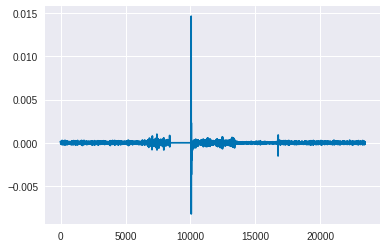

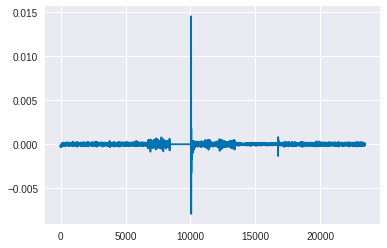

ValueError: operands could not be broadcast together with shapes (26773,) (23426,) 

In [38]:
plt.plot(sm_fit.gen_sound()[sm_fit.gestures[4][0]:sm_fit.gesture_end(10)])
plt.show()
plt.plot(sm_fit.gen_sound(range(4, 11)))
plt.show()
plt.plot(sm_fit.gen_sound()[sm_fit.gestures[4][0]:sm_fit.gesture_end(11)] - sm_fit.gen_sound(range(4, 11)))

In [ ]:
ibeg = 4
iend = 12
beg = sm_fit.gestures[ibeg][0]
end = sm_fit.gesture_end(iend)
synth_whole_feat = bsa.normalize_features(bsa.all_song_features(sm_fit.gen_sound(), 44100, freq_range=256, fft_step=40, fft_size=1024))
synth_part_feat = bsa.normalize_features(bsa.all_song_features(sm_fit.gen_sound(range(ibeg, iend+1)), 44100, freq_range=256, fft_step=40, fft_size=1024))
whole_ts_measure = bsa.normalize_features(bsa.all_song_features(ts, 44100, freq_range=256, fft_step=40, fft_size=1024))
part_ts_measure = bsa.normalize_features(bsa.all_song_features(ts[beg:end], 44100, freq_range=256, fft_step=40, fft_size=1024))

In [ ]:
for nfeat in part_feat:
    plt.figure(figsize=(14, 4))
    plt.plot(synth_part_feat[nfeat][500//40:-500//40], label="synth")
    plt.plot(synth_whole_feat[nfeat][(beg+500)//40:(end-500)//40], label="synth whole")
    #plt.plot(whole_ts_measure[nfeat][beg//40:end//40], label="whole")
    #plt.plot(part_ts_measure[nfeat], label="part")
    # plt.axvspan(sm_fit.gestures[6][0]//40, sm_fit.gesture_end(8)//40, alpha=0.1, color="b")
    plt.legend()
    plt.title(nfeat.title())
    plt.show()

In [ ]:
for i in range(0, 2001, 500):
    shift = bsa.normalize_features(bsa.all_song_features(synthesize(sm_fit.gen_alphabeta(range(ibeg, iend+1))[i:, :]), 44100, freq_range=256, fft_step=40, fft_size=1024))
    control = bsa.normalize_features(bsa.all_song_features(sm_fit.gen_sound(range(ibeg, iend+1)), 44100, freq_range=256, fft_step=40, fft_size=1024))
    plt.figure(figsize=(14,4))
    print(i)
    plt.plot(sm_fit.gen_alphabeta(range(ibeg, iend+1))[i:, :])
    plt.show()
    plt.figure(figsize=(14, 4))
    plt.plot(shift['entropy'], label="shifted")
    plt.plot(control['entropy'][len(control['entropy'])-len(shift['entropy']):], label="control")
    plt.legend()
    plt.show()